Covid-19 has affected the entire world in an unpredictable manner. There is lot of uncertainty regarding the treatment of corona patients. Due to this patients are being admitted to hospitals which in turn leads to  shortage of resources at hospitals. Even the best hospitals in New York have been suffering from shortage of resources due to limited resource availability.

In this project we aim to utilize Machine Learning and its capability to predict the approximate resources that would be required in the coming day so that health care workers can better prepare for the same and redirect resources as necessary which would ultimately lead to better care of patients. This will also allow health care workers to better plan their own schedules and prepare themselves for the coming day.

In this notebook, we use the data available to us to try to predict the number of people who would be hospitalized on the next day. 

**Load Libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pickle

**Read File Path**

In [ ]:
file = "../input/uncover/RDSC-07-30-Update/RDSC-07-30-Update/coronadatascraper/coronadatascraper-timeseries.csv"
covid_stats = pd.read_csv(file)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Preprocessing**

In [ ]:
X_columns = ['state', 'country',
       'population', 'lat', 'long', 'cases',
       'deaths', 'recovered', 'active', 'tested',
       'hospitalized_current', 'icu', 'icu_current',
       'growthfactor', 'date']

covid_stats['date'] = pd.to_datetime(covid_stats['date'])

covid_stats_X = covid_stats[X_columns]

**Remove rows with Hospitalized Resources null**

In [ ]:
df1 = covid_stats_X.loc[
    (covid_stats_X['hospitalized_current'].notnull())
]

**Helper Function for creating Lags**

In [ ]:
id_cols = ['date','country','state','population']

def lag_feature(df, lags, col):
    tmp = df[id_cols + [col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = id_cols + [(col+'_lag_'+str(i))]
        shifted['date'] += timedelta(days=i)
        df = pd.merge(df, shifted, on=id_cols, how='left')
    return df

**Create Lags for Selected Columns**

In [ ]:
cases_to_consider = ['hospitalized_current','deaths','tested']

for c in cases_to_consider:
    if c == 'hospitalized_current':
        df1 = lag_feature(df1,[1,3,7],c)
    if c == 'deaths':
        df1 = lag_feature(df1,[1],c)
    if c == 'tested':
        df1 = lag_feature(df1,[7],c)

**New Data with Lags**

In [ ]:
df1.head()

,state,country,population,lat,long,cases,deaths,recovered,active,tested,hospitalized_current,icu,icu_current,growthfactor,date,hospitalized_current_lag_1,hospitalized_current_lag_3,hospitalized_current_lag_7,deaths_lag_1,tested_lag_7
0,Flanders,Belgium,1847486.0,51.2485,4.7175,224.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,1.12,2020-03-15,NaN,NaN,NaN,NaN,NaN
1,Flanders,Belgium,1847486.0,51.2485,4.7175,270.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN,1.21,2020-03-16,8.0,NaN,NaN,NaN,NaN
2,Flanders,Belgium,1847486.0,51.2485,4.7175,324.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,1.20,2020-03-17,12.0,NaN,NaN,NaN,NaN
3,Flanders,Belgium,1847486.0,51.2485,4.7175,379.0,NaN,NaN,NaN,NaN,35.0,NaN,NaN,1.17,2020-03-18,17.0,8.0,NaN,NaN,NaN
4,Flanders,Belgium,1847486.0,51.2485,4.7175,461.0,NaN,NaN,NaN,NaN,35.0,NaN,NaN,1.22,2020-03-19,35.0,12.0,NaN,NaN,NaN


**Label Encoding for columns to support XG-Boost**

In [ ]:
df1['state'] = df1['state'].astype(str)

LE = preprocessing.LabelEncoder()

df1['state'] = LE.fit_transform(df1['state'])
df1['country'] = LE.fit_transform(df1['country'])


**XGB Initialization**

In [ ]:
model = xgb.XGBRegressor(max_depth=8,n_estimators=1000,
                     min_child_weight=300,colsample_bytree=0.8,
                     subsample=0.8,eta=0.3,seed=42)

**Train Validation Test Split**

In [ ]:
X = df1

X = shuffle(X)

Y = X['hospitalized_current']

X.drop(['hospitalized_current'],axis = 1,inplace=True)
X.drop(['cases'],axis = 1,inplace=True)
X.drop(['deaths'],axis = 1,inplace=True)
X.drop(['recovered'],axis = 1,inplace=True)
X.drop(['tested'],axis = 1,inplace=True)
X.drop(['date'],axis = 1,inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.30, random_state=42)

X_valid_a, X_test, y_valid_a, y_test = train_test_split(X_valid,y_valid,test_size = .10,random_state=42)

**Fit Model - it probably take ~4hrs**

In [ ]:
model.fit(X_train,y_train,eval_metric="rmse",
          eval_set=[(X_train, y_train), (X_valid_a, y_valid_a)],
          verbose=True,early_stopping_rounds = 10)

[0]	validation_0-rmse:24.91962	validation_1-rmse:25.04356
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:17.73775	validation_1-rmse:17.85986
[2]	validation_0-rmse:12.87242	validation_1-rmse:13.01716
[3]	validation_0-rmse:9.57686	validation_1-rmse:9.75882
[4]	validation_0-rmse:7.37026	validation_1-rmse:7.57925
[5]	validation_0-rmse:5.96388	validation_1-rmse:6.20665
[6]	validation_0-rmse:5.11903	validation_1-rmse:5.37822
[7]	validation_0-rmse:4.62646	validation_1-rmse:4.90813
[8]	validation_0-rmse:4.33340	validation_1-rmse:4.60979
[9]	validation_0-rmse:4.15426	validation_1-rmse:4.43009
[10]	validation_0-rmse:4.05138	validation_1-rmse:4.33572
[11]	validation_0-rmse:3.99859	validation_1-rmse:4.28312
[12]	validation_0-rmse:3.83739	validation_1-rmse:4.11676
[13]	validation_0-rmse:3.71325	validation_1-rmse:3.98717
[14]	validation_0-rmse:3.61192	validation_1-rms

[141]	validation_0-rmse:1.16187	validation_1-rmse:1.44556
[142]	validation_0-rmse:1.15584	validation_1-rmse:1.43911
[143]	validation_0-rmse:1.15410	validation_1-rmse:1.43712
[144]	validation_0-rmse:1.15244	validation_1-rmse:1.43672
[145]	validation_0-rmse:1.14791	validation_1-rmse:1.43164
[146]	validation_0-rmse:1.14185	validation_1-rmse:1.42498
[147]	validation_0-rmse:1.13961	validation_1-rmse:1.42413
[148]	validation_0-rmse:1.13668	validation_1-rmse:1.42447
[149]	validation_0-rmse:1.12571	validation_1-rmse:1.41418
[150]	validation_0-rmse:1.12269	validation_1-rmse:1.41160
[151]	validation_0-rmse:1.12075	validation_1-rmse:1.40918
[152]	validation_0-rmse:1.11700	validation_1-rmse:1.40483
[153]	validation_0-rmse:1.11269	validation_1-rmse:1.40093
[154]	validation_0-rmse:1.11117	validation_1-rmse:1.39993
[155]	validation_0-rmse:1.10679	validation_1-rmse:1.39724
[156]	validation_0-rmse:1.10468	validation_1-rmse:1.39889
[157]	validation_0-rmse:1.10065	validation_1-rmse:1.39440
[158]	validati

[283]	validation_0-rmse:0.82447	validation_1-rmse:1.16287
[284]	validation_0-rmse:0.82247	validation_1-rmse:1.16138
[285]	validation_0-rmse:0.82138	validation_1-rmse:1.16039
[286]	validation_0-rmse:0.82074	validation_1-rmse:1.16045
[287]	validation_0-rmse:0.81756	validation_1-rmse:1.15716
[288]	validation_0-rmse:0.81656	validation_1-rmse:1.15766
[289]	validation_0-rmse:0.81461	validation_1-rmse:1.15448
[290]	validation_0-rmse:0.81396	validation_1-rmse:1.15463
[291]	validation_0-rmse:0.81334	validation_1-rmse:1.15343
[292]	validation_0-rmse:0.81229	validation_1-rmse:1.15318
[293]	validation_0-rmse:0.81141	validation_1-rmse:1.15252
[294]	validation_0-rmse:0.81073	validation_1-rmse:1.15190
[295]	validation_0-rmse:0.81030	validation_1-rmse:1.15206
[296]	validation_0-rmse:0.80907	validation_1-rmse:1.15050
[297]	validation_0-rmse:0.80832	validation_1-rmse:1.15006
[298]	validation_0-rmse:0.80403	validation_1-rmse:1.14533
[299]	validation_0-rmse:0.80247	validation_1-rmse:1.14394
[300]	validati

[425]	validation_0-rmse:0.68247	validation_1-rmse:1.04518
[426]	validation_0-rmse:0.68158	validation_1-rmse:1.04403
[427]	validation_0-rmse:0.68107	validation_1-rmse:1.04340
[428]	validation_0-rmse:0.68010	validation_1-rmse:1.04233
[429]	validation_0-rmse:0.67931	validation_1-rmse:1.04214
[430]	validation_0-rmse:0.67809	validation_1-rmse:1.04140
[431]	validation_0-rmse:0.67746	validation_1-rmse:1.04076
[432]	validation_0-rmse:0.67706	validation_1-rmse:1.04088
[433]	validation_0-rmse:0.67613	validation_1-rmse:1.04038
[434]	validation_0-rmse:0.67515	validation_1-rmse:1.03931
[435]	validation_0-rmse:0.67476	validation_1-rmse:1.03934
[436]	validation_0-rmse:0.67376	validation_1-rmse:1.03782
[437]	validation_0-rmse:0.67216	validation_1-rmse:1.03649
[438]	validation_0-rmse:0.67141	validation_1-rmse:1.03633
[439]	validation_0-rmse:0.67109	validation_1-rmse:1.03596
[440]	validation_0-rmse:0.67041	validation_1-rmse:1.03535
[441]	validation_0-rmse:0.67007	validation_1-rmse:1.03558
[442]	validati

[567]	validation_0-rmse:0.60077	validation_1-rmse:0.97933
[568]	validation_0-rmse:0.60027	validation_1-rmse:0.97896
[569]	validation_0-rmse:0.59993	validation_1-rmse:0.97882
[570]	validation_0-rmse:0.59957	validation_1-rmse:0.97859
[571]	validation_0-rmse:0.59942	validation_1-rmse:0.97857
[572]	validation_0-rmse:0.59893	validation_1-rmse:0.97871
[573]	validation_0-rmse:0.59876	validation_1-rmse:0.97856
[574]	validation_0-rmse:0.59837	validation_1-rmse:0.97795
[575]	validation_0-rmse:0.59802	validation_1-rmse:0.97781
[576]	validation_0-rmse:0.59764	validation_1-rmse:0.97711
[577]	validation_0-rmse:0.59693	validation_1-rmse:0.97693
[578]	validation_0-rmse:0.59654	validation_1-rmse:0.97706
[579]	validation_0-rmse:0.59570	validation_1-rmse:0.97664
[580]	validation_0-rmse:0.59479	validation_1-rmse:0.97551
[581]	validation_0-rmse:0.59392	validation_1-rmse:0.97516
[582]	validation_0-rmse:0.59366	validation_1-rmse:0.97491
[583]	validation_0-rmse:0.59253	validation_1-rmse:0.97396
[584]	validati

[709]	validation_0-rmse:0.53787	validation_1-rmse:0.93198
[710]	validation_0-rmse:0.53751	validation_1-rmse:0.93186
[711]	validation_0-rmse:0.53632	validation_1-rmse:0.93109
[712]	validation_0-rmse:0.53547	validation_1-rmse:0.92971
[713]	validation_0-rmse:0.53487	validation_1-rmse:0.92869
[714]	validation_0-rmse:0.53441	validation_1-rmse:0.92845
[715]	validation_0-rmse:0.53368	validation_1-rmse:0.92775
[716]	validation_0-rmse:0.53332	validation_1-rmse:0.92719
[717]	validation_0-rmse:0.53295	validation_1-rmse:0.92653
[718]	validation_0-rmse:0.53237	validation_1-rmse:0.92639
[719]	validation_0-rmse:0.53214	validation_1-rmse:0.92605
[720]	validation_0-rmse:0.53178	validation_1-rmse:0.92518
[721]	validation_0-rmse:0.53156	validation_1-rmse:0.92497
[722]	validation_0-rmse:0.53120	validation_1-rmse:0.92477
[723]	validation_0-rmse:0.53092	validation_1-rmse:0.92533
[724]	validation_0-rmse:0.53081	validation_1-rmse:0.92517
[725]	validation_0-rmse:0.53054	validation_1-rmse:0.92477
[726]	validati

[851]	validation_0-rmse:0.49219	validation_1-rmse:0.89499
[852]	validation_0-rmse:0.49178	validation_1-rmse:0.89463
[853]	validation_0-rmse:0.49166	validation_1-rmse:0.89420
[854]	validation_0-rmse:0.49138	validation_1-rmse:0.89413
[855]	validation_0-rmse:0.49116	validation_1-rmse:0.89394
[856]	validation_0-rmse:0.49105	validation_1-rmse:0.89373
[857]	validation_0-rmse:0.49042	validation_1-rmse:0.89352
[858]	validation_0-rmse:0.49023	validation_1-rmse:0.89366
[859]	validation_0-rmse:0.48948	validation_1-rmse:0.89288
[860]	validation_0-rmse:0.48923	validation_1-rmse:0.89316
[861]	validation_0-rmse:0.48876	validation_1-rmse:0.89329
[862]	validation_0-rmse:0.48831	validation_1-rmse:0.89340
[863]	validation_0-rmse:0.48779	validation_1-rmse:0.89284
[864]	validation_0-rmse:0.48758	validation_1-rmse:0.89312
[865]	validation_0-rmse:0.48732	validation_1-rmse:0.89317
[866]	validation_0-rmse:0.48694	validation_1-rmse:0.89251
[867]	validation_0-rmse:0.48669	validation_1-rmse:0.89209
[868]	validati

[993]	validation_0-rmse:0.45353	validation_1-rmse:0.86727
[994]	validation_0-rmse:0.45338	validation_1-rmse:0.86742
[995]	validation_0-rmse:0.45328	validation_1-rmse:0.86723
[996]	validation_0-rmse:0.45306	validation_1-rmse:0.86701
[997]	validation_0-rmse:0.45282	validation_1-rmse:0.86628
[998]	validation_0-rmse:0.45254	validation_1-rmse:0.86618
[999]	validation_0-rmse:0.45233	validation_1-rmse:0.86624


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

**Helper function for plotting feature importance after XG BOOST**

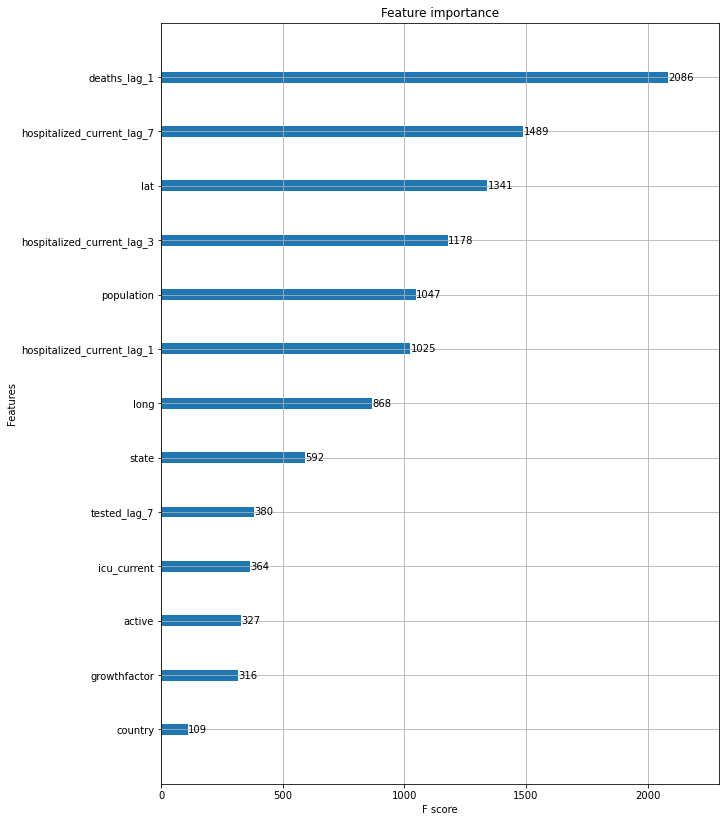

In [ ]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

**TESTING**

In [ ]:
y_test_pred = model.predict(X_test)
mean_squared_error(y_test, y_test_pred)

0.39198852894515196

**SAVE MODEL :)**

In [ ]:
filehandler = open('object_model_1.md', 'wb') 
pickle.dump(model, filehandler)